In [37]:
using ModelingToolkit, IntervalSets, Sophon, CairoMakie, Lux
using Optimization, OptimizationOptimJL

@parameters x,t
@variables θ(..), w(..)
Dₜ = Differential(t)
Dₜ² = Differential(t)^2
Dₓ = Differential(x)
Dₓ² = Differential(x)^2

g(x,t) = cos(t) - π/2 * sin(x)*cos(t)

eqs = [
    Dₜ²(θ(x,t)) - Dₓ²(θ(x,t)) + θ(x,t) - Dₓ(w(x,t)) ~ 0.0,
    Dₜ²(w(x,t)) - Dₓ²(w(x,t)) + Dₓ(θ(x,t)) ~ g(x,t)]

bcs = [
    θ(x, 0.0) ~ π/2*cos(x) + x - π/2,
    Dₜ(θ(x, 0.0)) ~ 0.0,
    w(x, 0.0) ~ π/2*sin(x),
    Dₜ(w(x, 0.0)) ~ 0.0,
    θ(0.0, t) ~ 0.0,
    θ(π, t) ~ 0.0,
    w(0.0, t) ~ 0.0, 
    w(π, t) ~ 0.0]

    
domains = [x ∈ Interval(0.0, π),
           t ∈ Interval(0.0, 1.0)]

@named timo = PDESystem(eqs, bcs, domains, [x,t], [θ(x,t),w(x,t)])

PDESystem
Equations: Equation[Differential(t)(Differential(t)(θ(x, t))) + θ(x, t) - Differential(x)(Differential(x)(θ(x, t))) - Differential(x)(w(x, t)) ~ 0.0, Differential(t)(Differential(t)(w(x, t))) + Differential(x)(θ(x, t)) - Differential(x)(Differential(x)(w(x, t))) ~ cos(t) - 1.5707963267948966cos(t)*sin(x)]
Boundary Conditions: Equation[θ(x, 0.0) ~ x + 1.5707963267948966cos(x) - 1.5707963267948966, Differential(t)(θ(x, 0.0)) ~ 0.0, w(x, 0.0) ~ 1.5707963267948966sin(x), Differential(t)(w(x, 0.0)) ~ 0.0, θ(0.0, t) ~ 0.0, θ(π, t) ~ 0.0, w(0.0, t) ~ 0.0, w(π, t) ~ 0.0]
Domain: Symbolics.VarDomainPairing[Symbolics.VarDomainPairing(x, 0.0..3.141592653589793), Symbolics.VarDomainPairing(t, 0.0..1.0)]
Dependent Variables: Num[θ(x, t), w(x, t)]
Independent Variables: Num[x, t]
Parameters: SciMLBase.NullParameters()
Default Parameter ValuesDict{Any, Any}()

In [59]:
pinn = PINN(θ = FullyConnected(2,1, tanh; hidden_dims=16,num_layers=3),
            w = FullyConnected(2,1, tanh; hidden_dims=16,num_layers=3))

sampler = QuasiRandomSampler(3000, 500)
strategy = NonAdaptiveTraining(1, 10)

prob = Sophon.discretize(timo, pinn, sampler, strategy)

OptimizationProblem. In-place: true
u0: ComponentVector{Float64}(θ = (layer_1 = (weight = [0.20482999086380005 -0.20002096891403198; 0.017888545989990234 -0.18271255493164062; … ; -0.3322269320487976 -0.17273187637329102; 0.029960334300994873 -0.09916025400161743], bias = [0.0; 0.0; … ; 0.0; 0.0;;]), layer_2 = (weight = [-0.1471254527568817 0.22109611332416534 … 0.008368191309273243 -0.1269519180059433; 0.29227742552757263 0.3135388195514679 … -0.21561706066131592 -0.607786238193512; … ; -0.013621232472360134 0.38421931862831116 … 0.18723651766777039 0.17183925211429596; 0.14659525454044342 0.22772659361362457 … -0.5937729477882385 -0.46388891339302063], bias = [0.0; 0.0; … ; 0.0; 0.0;;]), layer_3 = (weight = [0.22345679998397827 0.26517409086227417 … 0.19617076218128204 0.4145044684410095; -0.5361312627792358 0.4469732344150543 … 0.04176189377903938 0.24124255776405334; … ; 0.2248741090297699 -0.6019240021705627 … -0.4414461553096771 0.2731401324272156; -0.39874744415283203 -0.2168037

In [61]:
function callback(p, l)
    println("Loss: $l")
    return false
end

@time res = Optimization.solve(prob, BFGS(); maxiters=3000, callback=callback)

Loss: 2.4339054752514564e-7


Loss: 2.433601748933551e-7


Loss: 2.4333533972870825e-7


Loss: 2.433096627264442e-7


Loss: 2.4329215334354167e-7


Loss: 2.432771865951715e-7


Loss: 2.432121362839248e-7


Loss: 2.4311467939645254e-7


Loss: 2.4302891958745125e-7


Loss: 2.429988106282496e-7


Loss: 2.4294632235106047e-7


Loss: 2.4291575256403734e-7


Loss: 2.4289202888667046e-7


Loss: 2.4284731434884626e-7


Loss: 2.428279281948239e-7


Loss: 2.428034412592703e-7


Loss: 2.4277810522004393e-7


Loss: 2.427462883551667e-7


Loss: 2.4270308355859884e-7


Loss: 2.426129682617385e-7


Loss: 2.425394177706898e-7


Loss: 2.4242652616102767e-7


Loss: 2.4227970157742283e-7


Loss: 2.42221415078981e-7


Loss: 2.4217478687241344e-7


Loss: 2.4213974369118396e-7


Loss: 2.420522737373234e-7


Loss: 2.4201506572101883e-7


Loss: 2.419869281145131e-7


Loss: 2.419079456142814e-7


Loss: 2.4175922265121566e-7


Loss: 2.415878904146716e-7


Loss: 2.41499801515211e-7


Loss: 2.412452635866684e-7


Loss: 2.4106457415111786e-7


Loss: 2.4046253099900674e-7


Loss: 2.4008702527166394e-7


Loss: 2.395544028559637e-7


Loss: 2.393515053150951e-7


Loss: 2.386069123580383e-7


Loss: 2.3740288986033189e-7


Loss: 2.3665095969590194e-7


Loss: 2.3636772489621302e-7


Loss: 2.361382276893365e-7


Loss: 2.3562120964843348e-7


Loss: 2.3427308463323954e-7


Loss: 2.3375985773461434e-7


Loss: 2.3355062948571286e-7


Loss: 2.3328382327631798e-7


Loss: 2.327238991292063e-7


Loss: 2.3237085202247867e-7


Loss: 2.318474394722207e-7


Loss: 2.3120123363490374e-7


Loss: 2.3089214207753609e-7


Loss: 2.3075067833387646e-7


Loss: 2.3039872772564824e-7


Loss: 2.298792262463434e-7


Loss: 2.2956292590683122e-7


Loss: 2.2926144971052344e-7


Loss: 2.2897836929270805e-7


Loss: 2.2892377438752403e-7


Loss: 2.2871036541711755e-7


Loss: 2.2804618742744657e-7


Loss: 2.2795353241532058e-7


Loss: 2.278660333123832e-7


Loss: 2.276803922825337e-7


Loss: 2.2755403773202657e-7


Loss: 2.2732755662097773e-7


Loss: 2.272190566531609e-7


Loss: 2.271845111462951e-7


Loss: 2.269286082463132e-7


Loss: 2.2602041428845943e-7


Loss: 2.2552167025619437e-7


Loss: 2.2542436487697457e-7


Loss: 2.2537132251397884e-7


Loss: 2.2529121551550982e-7


Loss: 2.2514023331432026e-7


Loss: 2.247587023763172e-7


Loss: 2.24435731171445e-7


Loss: 2.2415492326792904e-7


Loss: 2.2390505771684177e-7


Loss: 2.237271064766935e-7


Loss: 2.236142490254665e-7


Loss: 2.2353979225528426e-7


Loss: 2.2347720836254013e-7


Loss: 2.2299708404382668e-7


Loss: 2.2286637145643593e-7


Loss: 2.2282101310050215e-7


Loss: 2.2265141181422282e-7


Loss: 2.214059538327078e-7


Loss: 2.2061146943711238e-7


Loss: 2.196691125715175e-7


Loss: 2.192989289697532e-7


Loss: 2.19141555101986e-7


Loss: 2.1903250577974434e-7


Loss: 2.18877495373683e-7


Loss: 2.1866486988198156e-7


Loss: 2.1794947566804193e-7


Loss: 2.1667683971581974e-7


Loss: 2.1632414365781679e-7


Loss: 2.1583758060267894e-7


Loss: 2.1431075215752303e-7


Loss: 2.1350269866053841e-7


Loss: 2.1312802067991088e-7


Loss: 2.1257356004900917e-7


Loss: 2.121752382699162e-7


Loss: 2.1141076468570886e-7


Loss: 2.1100058968543046e-7


Loss: 2.103462505948732e-7


Loss: 2.100597062820297e-7


Loss: 2.096909060653114e-7


Loss: 2.094318103532425e-7


Loss: 2.0922982510996245e-7


Loss: 2.089526563662806e-7


Loss: 2.084722026884124e-7


Loss: 2.0800623279713501e-7


Loss: 2.078283387966478e-7


Loss: 2.0737755033606953e-7


Loss: 2.0690838568473679e-7


Loss: 2.067544695989405e-7


Loss: 2.0618478692606637e-7


Loss: 2.058769116922447e-7


Loss: 2.0550768004060135e-7


Loss: 2.051591302542988e-7


Loss: 2.048235821865904e-7


Loss: 2.045766485372517e-7


Loss: 2.0444123157057753e-7


Loss: 2.042800379917242e-7


Loss: 2.0413202111747576e-7


Loss: 2.0403508850982541e-7


Loss: 2.0394327153606126e-7


Loss: 2.0388605626816557e-7


Loss: 2.038452937690668e-7


Loss: 2.0376133890986797e-7


Loss: 2.0331828450010066e-7


Loss: 2.0271846991985815e-7


Loss: 2.0249983610078893e-7


Loss: 2.023971185194516e-7


Loss: 2.0223191524042235e-7


Loss: 2.0192336669135724e-7


Loss: 2.014078215535606e-7


Loss: 2.0068216653714186e-7


Loss: 2.0054242166517676e-7


Loss: 2.004975257409296e-7


Loss: 2.0038094853865805e-7


Loss: 1.9974194085075622e-7


Loss: 1.9842618336638067e-7


Loss: 1.9748493690109787e-7


Loss: 1.959339118721399e-7


Loss: 1.9506698644274416e-7


Loss: 1.9469393159677963e-7


Loss: 1.9461392731203082e-7


Loss: 1.9456031598048674e-7


Loss: 1.945184929907881e-7


Loss: 1.9446553249205275e-7


Loss: 1.9433214535682355e-7


Loss: 1.9383442475908683e-7


Loss: 1.9299576796281056e-7


Loss: 1.9239683329495294e-7


Loss: 1.9208758688723313e-7


Loss: 1.9184582557465072e-7


Loss: 1.9172799575103197e-7


Loss: 1.916859681276807e-7


Loss: 1.9161026219191146e-7


Loss: 1.9115049540146144e-7


Loss: 1.9004655561261055e-7


Loss: 1.8896119351394423e-7


Loss: 1.883704364829614e-7


Loss: 1.8785332517850978e-7


Loss: 1.875212372671003e-7


Loss: 1.8723716286264334e-7


Loss: 1.8693524719133187e-7


Loss: 1.8668464327560889e-7


Loss: 1.8642401434809227e-7


Loss: 1.8628461308014004e-7


Loss: 1.8619096121098245e-7


Loss: 1.8611638184536427e-7


Loss: 1.8607490771374158e-7


Loss: 1.860385561736181e-7


Loss: 1.8598915099781336e-7


Loss: 1.8587596872084648e-7


Loss: 1.8552185829851352e-7


Loss: 1.8499566341099496e-7


Loss: 1.8464643758789753e-7


Loss: 1.8435224219472484e-7


Loss: 1.838503252878897e-7


Loss: 1.8292831591416262e-7


Loss: 1.8254292090289122e-7


Loss: 1.8220435215533138e-7


Loss: 1.819888684805875e-7


Loss: 1.8185277560638711e-7


Loss: 1.818046688201071e-7


Loss: 1.8176642170232884e-7


Loss: 1.8167784897027822e-7


Loss: 1.815281192532956e-7


Loss: 1.8138227041616775e-7


Loss: 1.8119386716509622e-7


Loss: 1.8069786623446125e-7


Loss: 1.8013597667424578e-7


Loss: 1.7991370188615034e-7


Loss: 1.7972316428153267e-7


Loss: 1.7943149484676632e-7


Loss: 1.7896308309199699e-7


Loss: 1.786792555395874e-7


Loss: 1.784974293651269e-7


Loss: 1.7832907326095442e-7


Loss: 1.7819166908173672e-7


Loss: 1.781300550256334e-7


Loss: 1.7808165639008548e-7


Loss: 1.7803742769163714e-7


Loss: 1.7800276462879372e-7


Loss: 1.7795685357195527e-7


Loss: 1.7788469879386318e-7


Loss: 1.7776291584642484e-7


Loss: 1.7751055978472935e-7


Loss: 1.7727232797003732e-7


Loss: 1.7688493524009574e-7


Loss: 1.763844256654405e-7


Loss: 1.759337074954579e-7


Loss: 1.750472384328346e-7


Loss: 1.7450923805774163e-7


Loss: 1.7411898229900931e-7


Loss: 1.7389984220464414e-7


Loss: 1.7378861895603938e-7


Loss: 1.7370710624289982e-7


Loss: 1.7363444367934827e-7


Loss: 1.7356604651192195e-7


Loss: 1.7350247429098648e-7


Loss: 1.734166545614968e-7


Loss: 1.7332382270525232e-7


Loss: 1.732322330909275e-7


Loss: 1.7318230825576478e-7


Loss: 1.7316068981654104e-7


Loss: 1.7314741307049545e-7


Loss: 1.7313556078519024e-7


Loss: 1.7310589707725445e-7


Loss: 1.7302166141586783e-7


Loss: 1.7261819767556906e-7


Loss: 1.7141521626820432e-7


Loss: 1.7012030661785544e-7


Loss: 1.6867155479475364e-7


Loss: 1.6807789017483163e-7


Loss: 1.673180482229328e-7


Loss: 1.6646786267205284e-7


Loss: 1.6617664886551297e-7


Loss: 1.6589840795093953e-7


Loss: 1.6564686636736615e-7


Loss: 1.6522360730563326e-7


Loss: 1.6494284008190435e-7


Loss: 1.6464584135639746e-7


Loss: 1.6434243321109463e-7


Loss: 1.6409581870731485e-7


Loss: 1.6392537363475377e-7


Loss: 1.6378451304824455e-7


Loss: 1.6370500687391718e-7


Loss: 1.636250862804491e-7


Loss: 1.6354367260606274e-7


Loss: 1.6349214903366967e-7


Loss: 1.634382961609444e-7


Loss: 1.6338364233192733e-7


Loss: 1.633454518341297e-7


Loss: 1.633268662864419e-7


Loss: 1.6329499678838065e-7


Loss: 1.6321703286584026e-7


Loss: 1.631408539526227e-7


Loss: 1.6304566255131305e-7


Loss: 1.6291715978113934e-7


Loss: 1.6261369427569036e-7


Loss: 1.620694363032554e-7


Loss: 1.6062777758976258e-7


Loss: 1.6005712406844123e-7


Loss: 1.5909520955470507e-7


Loss: 1.5863715930662176e-7


Loss: 1.5833242799153722e-7


Loss: 1.582107184864325e-7


Loss: 1.5807076407109947e-7


Loss: 1.5797932487795267e-7


Loss: 1.5786637065282276e-7


Loss: 1.5779146889469453e-7


Loss: 1.5775529176548185e-7


Loss: 1.5773594246542928e-7


Loss: 1.5772044974187892e-7


Loss: 1.5767936568201022e-7


Loss: 1.5756711418629112e-7


Loss: 1.5739251890095288e-7


Loss: 1.5707727725242063e-7


Loss: 1.5618772868258657e-7


Loss: 1.5474312828000674e-7


Loss: 1.531004843913177e-7


Loss: 1.5257858957117004e-7


Loss: 1.5152640807263366e-7


Loss: 1.5074922575590458e-7


Loss: 1.4969470462489986e-7


Loss: 1.4913111218005646e-7


Loss: 1.4844935035439428e-7


Loss: 1.4815279552939336e-7


Loss: 1.479497539025829e-7


Loss: 1.4781121342172302e-7


Loss: 1.4770832611171984e-7


Loss: 1.4765733705720875e-7


Loss: 1.476122607742182e-7


Loss: 1.4755257019092242e-7


Loss: 1.4750078473388094e-7


Loss: 1.474337269679285e-7


Loss: 1.473523411611994e-7


Loss: 1.4725780390761805e-7


Loss: 1.4712410637977741e-7


Loss: 1.4689202572232288e-7


Loss: 1.4660556889105174e-7


Loss: 1.4615129405590908e-7


Loss: 1.4548169608604128e-7


Loss: 1.4438282060232273e-7


Loss: 1.4325800207172993e-7


Loss: 1.4229545670854825e-7


Loss: 1.4190043456971196e-7


Loss: 1.4137387599025995e-7


Loss: 1.4109124433651135e-7


Loss: 1.4082870907080266e-7


Loss: 1.4064805282321905e-7


Loss: 1.4051030321414099e-7


Loss: 1.403712055140583e-7


Loss: 1.4016252693486662e-7


Loss: 1.3999730299196864e-7


Loss: 1.398060886457462e-7


Loss: 1.3956697289359575e-7


Loss: 1.3938905362525618e-7


Loss: 1.3922557615913812e-7


Loss: 1.3906445301395956e-7


Loss: 1.389493773835048e-7


Loss: 1.3886311622125227e-7


Loss: 1.3881009037125853e-7


Loss: 1.3875443665263692e-7


Loss: 1.3870904511565455e-7


Loss: 1.3864330808054774e-7


Loss: 1.3860704200408411e-7


Loss: 1.385697587067074e-7


Loss: 1.3853241738779258e-7


Loss: 1.3849082540955403e-7


Loss: 1.3843959504724816e-7


Loss: 1.3838606333539145e-7


Loss: 1.3832578391054112e-7


Loss: 1.3821159302298088e-7


Loss: 1.3803808080098147e-7


Loss: 1.3774562841404868e-7


Loss: 1.3716387720556047e-7


Loss: 1.3607520548970353e-7


Loss: 1.3489084948244357e-7


Loss: 1.3423147051713327e-7


Loss: 1.337878014912334e-7


Loss: 1.3352464964597872e-7


Loss: 1.3327782152236455e-7


Loss: 1.3314984620262523e-7


Loss: 1.3283824553872987e-7


Loss: 1.3264405307482772e-7


Loss: 1.324516478504692e-7


Loss: 1.3230549721604718e-7


Loss: 1.321815135874486e-7


Loss: 1.3199343076364547e-7


Loss: 1.3184624571989152e-7


Loss: 1.3173374620271331e-7


Loss: 1.3161888634164178e-7


Loss: 1.315455188383476e-7


Loss: 1.314564651663897e-7


Loss: 1.3134320802179344e-7


Loss: 1.3125369830588356e-7


Loss: 1.312086147465265e-7


Loss: 1.311857922803708e-7


Loss: 1.31152294128392e-7


Loss: 1.3109911197567158e-7


Loss: 1.3098290301363312e-7


Loss: 1.3084294962848183e-7


Loss: 1.3076773144331603e-7


Loss: 1.30693795443262e-7


Loss: 1.3059319298933897e-7


Loss: 1.3038200214803017e-7


Loss: 1.2991557894325328e-7


Loss: 1.2907223642839032e-7


Loss: 1.2872284385067807e-7


Loss: 1.280682218697334e-7


Loss: 1.277983491149722e-7


Loss: 1.2703031024544241e-7


Loss: 1.264613148925217e-7


Loss: 1.257709227427677e-7


Loss: 1.251558184305786e-7


Loss: 1.2445272611232723e-7


Loss: 1.2408126253736838e-7


Loss: 1.237499453026649e-7


Loss: 1.236028716286137e-7


Loss: 1.234327425711792e-7


Loss: 1.2333258812063342e-7


Loss: 1.232133258357581e-7


Loss: 1.230779127302254e-7


Loss: 1.2300020535646178e-7


Loss: 1.229098842429409e-7


Loss: 1.2280574307724413e-7


Loss: 1.2271205351344858e-7


Loss: 1.2263855596690488e-7


Loss: 1.2256999101501452e-7


Loss: 1.2251031433686964e-7


Loss: 1.2245882431102838e-7


Loss: 1.2239789777849912e-7


Loss: 1.2233440044237284e-7


Loss: 1.222339007982295e-7


Loss: 1.2207317182360309e-7


Loss: 1.2186746778054035e-7


Loss: 1.217822433537035e-7


Loss: 1.2162449762040513e-7


Loss: 1.2146167074433274e-7


Loss: 1.21361475719904e-7


Loss: 1.2124063592687988e-7


Loss: 1.210764257738675e-7


Loss: 1.2090021425809736e-7


Loss: 1.2066464065696915e-7


Loss: 1.205293655648213e-7


Loss: 1.2031269434111883e-7


Loss: 1.201177398752632e-7


Loss: 1.1985982762799107e-7


Loss: 1.1971385603259223e-7


Loss: 1.1947126355290838e-7


Loss: 1.193353306309213e-7


Loss: 1.1920474748216412e-7


Loss: 1.1899738308484229e-7


Loss: 1.1884021798584986e-7


Loss: 1.1864868679390838e-7


Loss: 1.1846659090687055e-7


Loss: 1.1819567019500567e-7


Loss: 1.178726129549686e-7


Loss: 1.1764386566926018e-7


Loss: 1.1729247726664901e-7


Loss: 1.1699534606695123e-7


Loss: 1.16642536291771e-7


Loss: 1.1623194279796166e-7


Loss: 1.1568356941878696e-7


Loss: 1.1474188336647088e-7


Loss: 1.1417507687002575e-7


Loss: 1.1370320036781279e-7


Loss: 1.1324575850390782e-7


Loss: 1.1315660220014589e-7


Loss: 1.1270605464050911e-7


Loss: 1.1240543043445154e-7


Loss: 1.120111201580026e-7


Loss: 1.113280971576181e-7


Loss: 1.1094506174766644e-7


Loss: 1.1026362887193638e-7


Loss: 1.0976159478685994e-7


Loss: 1.093816061504663e-7


Loss: 1.0886874669539766e-7


Loss: 1.0859109902662214e-7


Loss: 1.0831332356355982e-7


Loss: 1.0798036426974762e-7


Loss: 1.0787217852153031e-7


Loss: 1.0763098259100221e-7


Loss: 1.0746089820459737e-7


Loss: 1.0727611640124324e-7


Loss: 1.0705671768819218e-7


Loss: 1.0691082084351299e-7


Loss: 1.0663954137546363e-7


Loss: 1.0636344791451476e-7


Loss: 1.061530988473303e-7


Loss: 1.060018359204338e-7


Loss: 1.0589323233112432e-7


Loss: 1.0579262694083365e-7


Loss: 1.0566095375702679e-7


Loss: 1.0552194348645644e-7


Loss: 1.0540612333120436e-7


Loss: 1.0530834847350985e-7


Loss: 1.0525600723701992e-7


Loss: 1.0522970509982967e-7


Loss: 1.0520042609406428e-7


Loss: 1.0514347386676241e-7


Loss: 1.0505091168157586e-7


Loss: 1.0498565096874679e-7


Loss: 1.0492291220607008e-7


Loss: 1.0481667067938628e-7


Loss: 1.0474205866914384e-7


Loss: 1.046962380197165e-7


Loss: 1.0464395002515239e-7


Loss: 1.0454714228331202e-7


Loss: 1.0442475746447601e-7


Loss: 1.0426293465692963e-7


Loss: 1.0411750589411106e-7


Loss: 1.0399620154176618e-7


Loss: 1.0390150590980454e-7


Loss: 1.0380846751529914e-7


Loss: 1.0364199189045771e-7


Loss: 1.0332539253524561e-7


Loss: 1.0276328949644769e-7


Loss: 1.0227081853676441e-7


Loss: 1.0143728344921883e-7


Loss: 1.0086106736428769e-7


Loss: 1.0025151106703071e-7


Loss: 9.977692458854614e-8


Loss: 9.937956313590668e-8


Loss: 9.852196591330968e-8


Loss: 9.773584308840848e-8


Loss: 9.731106372970402e-8


Loss: 9.70764329972586e-8


Loss: 9.68030141016696e-8


Loss: 9.666972223124994e-8


Loss: 9.652527310586767e-8


Loss: 9.632861750060489e-8


Loss: 9.612936785015545e-8


Loss: 9.59034954100599e-8


Loss: 9.567272880731437e-8


Loss: 9.556858466899987e-8


Loss: 9.551497353354079e-8


Loss: 9.547752370973184e-8


Loss: 9.543013367737701e-8


Loss: 9.538105039952733e-8


Loss: 9.53401687530098e-8


Loss: 9.530303190284874e-8


Loss: 9.527707163332778e-8


Loss: 9.525303400295017e-8


Loss: 9.522616510163444e-8


Loss: 9.518091257438292e-8


Loss: 9.512482187106086e-8


Loss: 9.504692251382603e-8


Loss: 9.490764231946487e-8


Loss: 9.481859394276154e-8


Loss: 9.474016748270421e-8


Loss: 9.461394920756528e-8


Loss: 9.446120638342723e-8


Loss: 9.43178360817754e-8


Loss: 9.418674572589618e-8


Loss: 9.400119257604182e-8


Loss: 9.389052012830512e-8


Loss: 9.382430839684015e-8


Loss: 9.377689314878183e-8


Loss: 9.372262940503588e-8


Loss: 9.368947839380531e-8


Loss: 9.367173453592495e-8


Loss: 9.364396075379555e-8


Loss: 9.361322156443392e-8


Loss: 9.358786463373275e-8


Loss: 9.35582618470712e-8


Loss: 9.352868490319583e-8


Loss: 9.35031032378992e-8


Loss: 9.348791610840262e-8


Loss: 9.34759855207068e-8


Loss: 9.346146462313507e-8


Loss: 9.343903403036148e-8


Loss: 9.340838577709339e-8


Loss: 9.336970437871014e-8


Loss: 9.331699107581413e-8


Loss: 9.327385218171235e-8


Loss: 9.322934796941243e-8


Loss: 9.315224816460081e-8


Loss: 9.301845901360691e-8


Loss: 9.291946555667359e-8


Loss: 9.270898147585043e-8


Loss: 9.258207638578101e-8


Loss: 9.217551959437221e-8


Loss: 9.16300922384415e-8


Loss: 9.114563525153391e-8


Loss: 9.09797752032236e-8


Loss: 9.058934220570829e-8


Loss: 9.036141038495203e-8


Loss: 8.996127437307301e-8


Loss: 8.959254208661511e-8


Loss: 8.922507556280799e-8


Loss: 8.895495669829922e-8


Loss: 8.861879532289189e-8


Loss: 8.837325463457167e-8


Loss: 8.822395333801404e-8


Loss: 8.80498589350998e-8


Loss: 8.786790128062825e-8


Loss: 8.771732932984894e-8


Loss: 8.759358979436014e-8


Loss: 8.748811659274439e-8


Loss: 8.736914981665767e-8


Loss: 8.724415215265044e-8


Loss: 8.712704545560199e-8


Loss: 8.703494017810128e-8


Loss: 8.691840317366878e-8


Loss: 8.678130782787023e-8


Loss: 8.668585444701284e-8


Loss: 8.664086198104427e-8


Loss: 8.662091741255303e-8


Loss: 8.66047787956718e-8


Loss: 8.658091178971303e-8


Loss: 8.654657202321751e-8


Loss: 8.651965009873116e-8


Loss: 8.649437892814202e-8


Loss: 8.645236172401999e-8


Loss: 8.640893803898802e-8


Loss: 8.637178479728829e-8


Loss: 8.633968054230297e-8


Loss: 8.631319494110177e-8


Loss: 8.629277583886638e-8


Loss: 8.62718065624605e-8


Loss: 8.624227928061257e-8


Loss: 8.620209110003349e-8


Loss: 8.614590997917703e-8


Loss: 8.60073334356527e-8


Loss: 8.578967430910569e-8


Loss: 8.559581997165352e-8


Loss: 8.5448142904719e-8


Loss: 8.532000656952958e-8


Loss: 8.5145328229951e-8


Loss: 8.497378177765243e-8


Loss: 8.47979189997234e-8


Loss: 8.468948472068157e-8


Loss: 8.451489455698269e-8


Loss: 8.434680546556601e-8


Loss: 8.408264173431378e-8


Loss: 8.384999610015205e-8


Loss: 8.372712979439973e-8


Loss: 8.338390490890946e-8


Loss: 8.325639910737655e-8


Loss: 8.2776393046809e-8


Loss: 8.239905081224879e-8


Loss: 8.213551574585934e-8


Loss: 8.182801185124877e-8


Loss: 8.153827008938676e-8


Loss: 8.118851328875038e-8


Loss: 8.101828081200002e-8


Loss: 8.092591049672726e-8


Loss: 8.070999643623159e-8


Loss: 8.050422800557325e-8


Loss: 8.037374683721472e-8


Loss: 8.021948296050554e-8


Loss: 8.015329100260631e-8


Loss: 8.007164650924943e-8


Loss: 8.002938016421781e-8


Loss: 7.999543812042869e-8


Loss: 7.993108561653909e-8


Loss: 7.985742721892661e-8


Loss: 7.978437705593921e-8


Loss: 7.971708078382451e-8


Loss: 7.965347022993722e-8


Loss: 7.961699905891494e-8


Loss: 7.958019158152913e-8


Loss: 7.955933749454413e-8


Loss: 7.953798701124954e-8


Loss: 7.951077846812622e-8


Loss: 7.948185782202014e-8


Loss: 7.943866159951223e-8


Loss: 7.938891237057713e-8


Loss: 7.933563940715232e-8


Loss: 7.928848937822822e-8


Loss: 7.924989259811337e-8


Loss: 7.920654674272937e-8


Loss: 7.916059170241622e-8


Loss: 7.912911504636739e-8


Loss: 7.91038745955703e-8


Loss: 7.9086757989007e-8


Loss: 7.906791494746384e-8


Loss: 7.903126196269575e-8


Loss: 7.900413164832621e-8


Loss: 7.898628232585534e-8


Loss: 7.896632855760575e-8


Loss: 7.894313661458729e-8


Loss: 7.892545767823637e-8


Loss: 7.890857526588693e-8


Loss: 7.889675979731649e-8


Loss: 7.888277493750818e-8


Loss: 7.885743226213021e-8


Loss: 7.883237435457914e-8


Loss: 7.881563821719883e-8


Loss: 7.880265972936113e-8


Loss: 7.877666877288542e-8


Loss: 7.874722770252582e-8


Loss: 7.870606974087827e-8


Loss: 7.862364059502624e-8


Loss: 7.852606823357056e-8


Loss: 7.847256504302128e-8


Loss: 7.838612460468971e-8


Loss: 7.829313551612581e-8


Loss: 7.814242140963156e-8


Loss: 7.801188159422678e-8


Loss: 7.77378509951907e-8


Loss: 7.755619649868717e-8


Loss: 7.742565715486384e-8


Loss: 7.716503306078452e-8


Loss: 7.689391335679543e-8


Loss: 7.66826369796175e-8


Loss: 7.646767837873558e-8


Loss: 7.624030807055196e-8


Loss: 7.591739611245052e-8


Loss: 7.566377893571755e-8


Loss: 7.521646898547272e-8


Loss: 7.490686089396416e-8


Loss: 7.466659575561912e-8


Loss: 7.453025964781329e-8


Loss: 7.438210589136978e-8


Loss: 7.425667869776169e-8


Loss: 7.413486914556437e-8


Loss: 7.401609278405664e-8


Loss: 7.387821876991026e-8


Loss: 7.375488798930701e-8


Loss: 7.365323010330045e-8


Loss: 7.355384951093991e-8


Loss: 7.349810229696448e-8


Loss: 7.346172770031496e-8


Loss: 7.342592393468427e-8


Loss: 7.339703929333846e-8


Loss: 7.33701990969231e-8


Loss: 7.335106792791338e-8


Loss: 7.333347893840341e-8


Loss: 7.330847153978655e-8


Loss: 7.329592442280007e-8


Loss: 7.327752465988439e-8


Loss: 7.323831808417932e-8


Loss: 7.319430850649929e-8


Loss: 7.315447353395483e-8


Loss: 7.309705372825081e-8


Loss: 7.303092862581127e-8


Loss: 7.29814635476908e-8


Loss: 7.295430910217245e-8


Loss: 7.291945139489175e-8


Loss: 7.285851542164418e-8


Loss: 7.276569359584721e-8


Loss: 7.266519494555623e-8


Loss: 7.256981763440014e-8


Loss: 7.249505974285945e-8


Loss: 7.245406167477901e-8


Loss: 7.242429758098702e-8


Loss: 7.239461222956967e-8


Loss: 7.237530235034729e-8


Loss: 7.236046658172205e-8


Loss: 7.234964039039504e-8


Loss: 7.233750871591195e-8


Loss: 7.232167539087297e-8


Loss: 7.229882483767376e-8


Loss: 7.226951117671808e-8


Loss: 7.223312144200068e-8


Loss: 7.218443350707458e-8


Loss: 7.212487617828829e-8


Loss: 7.20331039928463e-8


Loss: 7.193582656669203e-8


Loss: 7.178182152218962e-8


Loss: 7.162667255390428e-8


Loss: 7.132475660533016e-8


Loss: 7.111936549697888e-8


Loss: 7.102362391686423e-8


Loss: 7.077922385865062e-8


Loss: 7.054276496142654e-8


Loss: 7.01216489181271e-8


Loss: 6.981910017664519e-8


Loss: 6.955049165931908e-8


Loss: 6.940754857023545e-8


Loss: 6.929057571956454e-8


Loss: 6.92518970062792e-8


Loss: 6.917441807612465e-8


Loss: 6.908222745277745e-8


Loss: 6.900739979642303e-8


Loss: 6.896320128540257e-8


Loss: 6.89393578834928e-8


Loss: 6.891261931545929e-8


Loss: 6.88752143328186e-8


Loss: 6.883636550619435e-8


Loss: 6.881103379512099e-8


Loss: 6.878861995601906e-8


Loss: 6.876442636411977e-8


Loss: 6.872629258577244e-8


Loss: 6.866824893602119e-8


Loss: 6.861569153376406e-8


Loss: 6.855413491646051e-8


Loss: 6.84714752319128e-8


Loss: 6.839367984546573e-8


Loss: 6.827562983134617e-8


Loss: 6.817746737188922e-8


Loss: 6.807463787732676e-8


Loss: 6.803502973509667e-8


Loss: 6.798479139304657e-8


Loss: 6.795028194176418e-8


Loss: 6.792094283483427e-8


Loss: 6.788371632916512e-8


Loss: 6.784976738258152e-8


Loss: 6.782342957647218e-8


Loss: 6.781071111681042e-8


Loss: 6.780405409256072e-8


Loss: 6.779241187712773e-8


Loss: 6.777287962638436e-8


Loss: 6.774111952200177e-8


Loss: 6.771737921573034e-8


Loss: 6.769793149937088e-8


Loss: 6.768527126256643e-8


Loss: 6.766230967129654e-8


Loss: 6.764871563414142e-8


Loss: 6.763261878605146e-8


Loss: 6.76163412247285e-8


Loss: 6.7599633111293e-8


Loss: 6.758638021578267e-8


Loss: 6.757246248249449e-8


Loss: 6.755818514028088e-8


Loss: 6.754776043661088e-8


Loss: 6.754107782589154e-8


Loss: 6.752686946606853e-8


Loss: 6.751013034568858e-8


Loss: 6.749428423377051e-8


Loss: 6.74826261136167e-8


Loss: 6.745885965726731e-8


Loss: 6.743284246558987e-8


Loss: 6.739537132554777e-8


Loss: 6.735944260162097e-8


Loss: 6.729903797246344e-8


Loss: 6.724415991469747e-8


Loss: 6.721799720195533e-8


Loss: 6.719403603564538e-8


Loss: 6.716477711531843e-8


Loss: 6.714271039276477e-8


Loss: 6.712129441099762e-8


Loss: 6.71053616584629e-8


Loss: 6.709526779316322e-8


Loss: 6.707901254405616e-8


Loss: 6.706353104441325e-8


Loss: 6.704809493789466e-8


Loss: 6.703305136815827e-8


Loss: 6.701630559503676e-8


Loss: 6.699851421206218e-8


Loss: 6.698525134775206e-8


Loss: 6.696999553716877e-8


Loss: 6.695238281450494e-8


Loss: 6.691754051308846e-8


Loss: 6.688168501371954e-8


Loss: 6.683011667170962e-8


Loss: 6.679142420014098e-8


Loss: 6.674093861297877e-8


Loss: 6.664448678848455e-8


Loss: 6.651548741776912e-8


Loss: 6.641563162864885e-8


Loss: 6.622175228518666e-8


Loss: 6.594450262095008e-8


Loss: 6.572602576592314e-8


Loss: 6.563857019937951e-8


Loss: 6.551561274060486e-8


Loss: 6.543008645218283e-8


Loss: 6.532589913383829e-8


Loss: 6.52077054743522e-8


Loss: 6.512818757820762e-8


Loss: 6.506532694599525e-8


Loss: 6.501040632721572e-8


Loss: 6.494976032603898e-8


Loss: 6.488882313394516e-8


Loss: 6.481503231333838e-8


Loss: 6.473012219207866e-8


Loss: 6.466550287851766e-8


Loss: 6.46250962643018e-8


Loss: 6.459506964176962e-8


Loss: 6.45589342725142e-8


Loss: 6.454073964324063e-8


Loss: 6.452170577181669e-8


Loss: 6.450675415241773e-8


Loss: 6.448606235182789e-8


Loss: 6.445219238711107e-8


Loss: 6.439842383732247e-8


Loss: 6.432435299300836e-8


Loss: 6.427512344778036e-8


Loss: 6.42552076501136e-8


Loss: 6.422771044993234e-8


Loss: 6.41889752934093e-8


Loss: 6.415854778589449e-8


Loss: 6.413857728930816e-8


Loss: 6.412275419154609e-8


Loss: 6.41046001791382e-8


Loss: 6.407718081045778e-8


Loss: 6.405177457905272e-8


Loss: 6.401715346166903e-8


Loss: 6.397118713030916e-8


Loss: 6.394184358610911e-8


Loss: 6.391157924626018e-8


Loss: 6.386509968209182e-8


Loss: 6.380629321778104e-8


Loss: 6.376597432870378e-8


Loss: 6.372787037566278e-8


Loss: 6.366963856806516e-8


Loss: 6.359973121640628e-8


Loss: 6.354374227009916e-8


Loss: 6.350503656246353e-8


Loss: 6.34541764469594e-8


Loss: 6.342686611062355e-8


Loss: 6.339881823229566e-8


Loss: 6.337762729537842e-8


Loss: 6.336263763871046e-8


Loss: 6.335148974331117e-8


Loss: 6.332530631840842e-8


Loss: 6.328145853430963e-8


Loss: 6.32131321234233e-8


Loss: 6.31320396306432e-8


Loss: 6.301937494992452e-8


Loss: 6.29938259211899e-8


Loss: 6.288082854036453e-8


Loss: 6.280521526764477e-8


Loss: 6.259727549731908e-8


Loss: 6.245416747837387e-8


Loss: 6.234947347440314e-8


Loss: 6.213955693834703e-8


Loss: 6.200656903791769e-8


Loss: 6.165295518797047e-8


Loss: 6.147252890257536e-8


Loss: 6.117146948934296e-8


Loss: 6.086229740823458e-8


Loss: 6.066291156022424e-8


Loss: 6.02465887965308e-8


Loss: 6.000324304608299e-8


Loss: 5.982272339625171e-8


Loss: 5.952562247559723e-8


Loss: 5.931637322948042e-8


Loss: 5.909083222160185e-8


Loss: 5.8877640179563564e-8


Loss: 5.871477045557284e-8


Loss: 5.8554205920085044e-8


Loss: 5.8368308037034685e-8


Loss: 5.8199906650814134e-8


Loss: 5.8059430635322616e-8


Loss: 5.796487599827245e-8


Loss: 5.787613308591465e-8


Loss: 5.776463532680286e-8


Loss: 5.7679328295671265e-8


Loss: 5.7590275264060695e-8


Loss: 5.744999727587757e-8


Loss: 5.736192817130657e-8


Loss: 5.7259195744724466e-8


Loss: 5.710082359814787e-8


Loss: 5.6971461798726975e-8


Loss: 5.688090165625928e-8


Loss: 5.6767392672578485e-8


Loss: 5.667966817876809e-8


Loss: 5.655973030949517e-8


Loss: 5.648783441777594e-8


Loss: 5.643236957892114e-8


Loss: 5.639213128051744e-8


Loss: 5.634161944260815e-8


Loss: 5.625371984416916e-8


Loss: 5.613833682164916e-8


Loss: 5.604460908046141e-8


Loss: 5.59667107669447e-8


Loss: 5.589057483307288e-8


Loss: 5.583561335861543e-8


Loss: 5.577539398651706e-8


Loss: 5.5692986624826364e-8


Loss: 5.562498694551037e-8


Loss: 5.557444122003575e-8


Loss: 5.553770581884429e-8


Loss: 5.54960351121865e-8


Loss: 5.5462961994071795e-8


Loss: 5.5426934165063087e-8


Loss: 5.534764198095235e-8


Loss: 5.527176162730784e-8


Loss: 5.523277183856995e-8


Loss: 5.520989686729491e-8


Loss: 5.518002409192765e-8


Loss: 5.515268272907965e-8


Loss: 5.513113130693471e-8


Loss: 5.510019301950583e-8


Loss: 5.5065043423235207e-8


Loss: 5.502905412325967e-8


Loss: 5.499964632193773e-8


Loss: 5.497978639865342e-8


Loss: 5.4963856714513374e-8


Loss: 5.494463975531627e-8


Loss: 5.492098670101651e-8


Loss: 5.48911342628212e-8


Loss: 5.486957952941068e-8


Loss: 5.48482719986292e-8


Loss: 5.483067987009723e-8


Loss: 5.481060658132878e-8


Loss: 5.479076495762335e-8


Loss: 5.477541332860185e-8


Loss: 5.4757386289697195e-8


Loss: 5.473969002636576e-8


Loss: 5.4726643565745786e-8


Loss: 5.471535266842917e-8


Loss: 5.4696429411185874e-8


Loss: 5.467194459335028e-8


Loss: 5.463640398679227e-8


Loss: 5.4600675223105314e-8


Loss: 5.4559311404149365e-8


Loss: 5.451802418605026e-8


Loss: 5.4500188948725697e-8


Loss: 5.44880570027524e-8


Loss: 5.4474628918986474e-8


Loss: 5.44608276255448e-8


Loss: 5.4444254900772154e-8


Loss: 5.440574784949374e-8


Loss: 5.435050873634737e-8


Loss: 5.423190207114297e-8


Loss: 5.3990282787035836e-8


Loss: 5.3742144570633826e-8


Loss: 5.356968184267942e-8


Loss: 5.343819485835306e-8


Loss: 5.334067792239348e-8


Loss: 5.31447508696573e-8


Loss: 5.298726093112095e-8


Loss: 5.2759459417562064e-8


Loss: 5.25826448389533e-8


Loss: 5.230514927770493e-8


Loss: 5.207681872239107e-8


Loss: 5.1901155107324066e-8


Loss: 5.168078081215022e-8


Loss: 5.1486105355245174e-8


Loss: 5.129171422751479e-8


Loss: 5.115163796465844e-8


Loss: 5.0977276677570324e-8


Loss: 5.0878239820782576e-8


Loss: 5.0732166044234496e-8


Loss: 5.065551172362552e-8


Loss: 5.055642607124511e-8


Loss: 5.041962418730396e-8


Loss: 5.0353397539115797e-8


Loss: 5.030009412108249e-8


Loss: 5.026698514611639e-8


Loss: 5.022006605108166e-8


Loss: 5.016875479884599e-8


Loss: 5.011184834557556e-8


Loss: 5.003618490728802e-8


Loss: 4.9960985532098486e-8


Loss: 4.9931364576084315e-8


Loss: 4.990986922557881e-8


Loss: 4.9889178688882e-8


Loss: 4.986505183911006e-8


Loss: 4.983915698544842e-8


Loss: 4.981354447828792e-8


Loss: 4.9797279694314136e-8


Loss: 4.978264063924834e-8


Loss: 4.976845453239375e-8


Loss: 4.975119511879897e-8


Loss: 4.973801177382936e-8


Loss: 4.972553796682351e-8


Loss: 4.9707215110400695e-8


Loss: 4.967988173737284e-8


Loss: 4.965781286281456e-8


Loss: 4.962522556454762e-8


Loss: 4.9599198114068613e-8


Loss: 4.956227309885215e-8


Loss: 4.953323031741651e-8


Loss: 4.947308062238402e-8


Loss: 4.9377659286848926e-8


Loss: 4.9321062737028595e-8


Loss: 4.922417702476169e-8


Loss: 4.9148854601850266e-8


Loss: 4.903740530644126e-8


Loss: 4.892892367227395e-8


Loss: 4.8794273133204194e-8


Loss: 4.865870115029399e-8


Loss: 4.851712704199778e-8


Loss: 4.841487745270262e-8


Loss: 4.8346979560044446e-8


Loss: 4.82416134700308e-8


Loss: 4.815030686258216e-8


Loss: 4.808946016486312e-8


Loss: 4.792786136026867e-8


Loss: 4.783286787359108e-8


Loss: 4.772828841679779e-8


Loss: 4.764353473161649e-8


Loss: 4.7592405295812724e-8


Loss: 4.7544474972104023e-8


Loss: 4.749009231600682e-8


Loss: 4.7414994176841854e-8


Loss: 4.7350597394200285e-8


Loss: 4.7283007901578626e-8


Loss: 4.723227176827292e-8


Loss: 4.7185421573731554e-8


Loss: 4.710878078358094e-8


Loss: 4.702780798884837e-8


Loss: 4.6909539228496034e-8


Loss: 4.684229907485439e-8


Loss: 4.6788721862831935e-8


Loss: 4.6720005139845446e-8


Loss: 4.665712000472752e-8


Loss: 4.660037358612189e-8


Loss: 4.657399663250762e-8


Loss: 4.655268640561074e-8


Loss: 4.652408922401035e-8


Loss: 4.6500528580994764e-8


Loss: 4.6472649481247744e-8


Loss: 4.6441883647390384e-8


Loss: 4.641174107675945e-8


Loss: 4.6372045699021217e-8


Loss: 4.632972351070526e-8


Loss: 4.628737871987165e-8


Loss: 4.6255670607211485e-8


Loss: 4.6224659496175045e-8


Loss: 4.6212853218996426e-8


Loss: 4.618969893623512e-8


Loss: 4.617531321601029e-8


Loss: 4.614957604048772e-8


Loss: 4.613308849799851e-8


Loss: 4.611274690961976e-8


Loss: 4.609759082517403e-8


Loss: 4.608248447871969e-8


Loss: 4.606645746923169e-8


Loss: 4.60468399933749e-8


Loss: 4.602799775335146e-8


Loss: 4.6020542799111064e-8


Loss: 4.601142029448386e-8


Loss: 4.600493611709915e-8


Loss: 4.599786287230165e-8


Loss: 4.599255229827403e-8


Loss: 4.598731184095877e-8


Loss: 4.5980355752218934e-8


Loss: 4.5975722475182835e-8


Loss: 4.5967634660742226e-8


Loss: 4.5953433553033665e-8


Loss: 4.593247097827129e-8


Loss: 4.591934423957289e-8


Loss: 4.588969967515662e-8


Loss: 4.5854071662049284e-8


Loss: 4.5831621361345206e-8


Loss: 4.581040127685111e-8


Loss: 4.579223728786986e-8


Loss: 4.5776415722582674e-8


Loss: 4.5753363746400866e-8


Loss: 4.572749769027219e-8


Loss: 4.5691986003536196e-8


Loss: 4.5651898297647435e-8


Loss: 4.5600238683746086e-8


Loss: 4.555569916852817e-8


Loss: 4.553277097026234e-8


Loss: 4.550574531748404e-8


Loss: 4.547814116151391e-8


Loss: 4.5456115255520797e-8


Loss: 4.5440488359885756e-8


Loss: 4.5415232498093815e-8


Loss: 4.538647865676061e-8


Loss: 4.535424685404209e-8


Loss: 4.533200735176061e-8


Loss: 4.530612460752533e-8


Loss: 4.527685799533475e-8


Loss: 4.525041855169628e-8


Loss: 4.521606677009541e-8


Loss: 4.5197562814998073e-8


Loss: 4.518295265589023e-8


Loss: 4.517507018908366e-8


Loss: 4.516173423481072e-8


Loss: 4.514725254102935e-8


Loss: 4.512542721518955e-8


Loss: 4.510403943382266e-8


Loss: 4.508673143517486e-8


Loss: 4.5070310675894776e-8


Loss: 4.505687902433569e-8


Loss: 4.504418039224289e-8


Loss: 4.50248949699863e-8


Loss: 4.5000308604765e-8


Loss: 4.497466882508149e-8


Loss: 4.49487422894206e-8


Loss: 4.492702148194516e-8


Loss: 4.489670484770484e-8


Loss: 4.4867225872559956e-8


Loss: 4.4834583920667295e-8


Loss: 4.477923738796161e-8


Loss: 4.466890875228762e-8


Loss: 4.453523825020053e-8


Loss: 4.4481947583664775e-8


Loss: 4.4359228681998676e-8


Loss: 4.427657069196523e-8


Loss: 4.4204792750041154e-8


Loss: 4.413643704525512e-8


Loss: 4.404758094008152e-8


Loss: 4.39702609754612e-8


Loss: 4.391519261959107e-8


Loss: 4.3868147567876825e-8


Loss: 4.381814661312071e-8


Loss: 4.37700075054325e-8


Loss: 4.373986066778962e-8


Loss: 4.3702157109376296e-8


Loss: 4.365699750444603e-8


Loss: 4.360978152812097e-8


Loss: 4.356896220414181e-8


Loss: 4.352052143983308e-8


Loss: 4.345249391285941e-8


Loss: 4.332553385122274e-8


Loss: 4.323302062578436e-8


Loss: 4.3147854387488884e-8


Loss: 4.305389221671611e-8


Loss: 4.296552664270863e-8


Loss: 4.288036710708975e-8


Loss: 4.279275798840014e-8


Loss: 4.27155411574649e-8


Loss: 4.264539987074522e-8


Loss: 4.2559015700660425e-8


Loss: 4.251195030796667e-8


Loss: 4.244792655722054e-8


Loss: 4.234960701091606e-8


Loss: 4.219550296414191e-8


Loss: 4.199415935709442e-8


Loss: 4.166522288008985e-8


Loss: 4.160717738415419e-8


Loss: 4.147879618826037e-8


Loss: 4.131788627263635e-8


Loss: 4.1042896474246804e-8


Loss: 4.0662161315858254e-8


Loss: 4.047827574819927e-8


Loss: 4.036041760727037e-8


Loss: 4.016861579542985e-8


Loss: 4.002957274170744e-8


Loss: 3.984890634927929e-8


Loss: 3.976486269510807e-8


Loss: 3.964404241878703e-8


Loss: 3.954603032415466e-8


Loss: 3.9448268177971055e-8


Loss: 3.928860583452026e-8


Loss: 3.909934577574006e-8


Loss: 3.8969786988879787e-8


Loss: 3.891640757100692e-8


Loss: 3.8808916018488387e-8


Loss: 3.873287488958166e-8


Loss: 3.8673281797602406e-8


Loss: 3.8610708198003494e-8


Loss: 3.853771665190994e-8


Loss: 3.848006536774401e-8


Loss: 3.844553249477679e-8


Loss: 3.842209986580528e-8


Loss: 3.840487512456183e-8


Loss: 3.83849428919139e-8


Loss: 3.836933228400452e-8


Loss: 3.835991948730477e-8


Loss: 3.83454481518016e-8


Loss: 3.832832592332086e-8


Loss: 3.8311594133004093e-8


Loss: 3.830000061021175e-8


Loss: 3.829152596731108e-8


Loss: 3.8286197697519115e-8


Loss: 3.828144345938245e-8


Loss: 3.8276209043227766e-8


Loss: 3.826357043173398e-8


Loss: 3.823746779218653e-8


Loss: 3.820606598802262e-8


Loss: 3.8174830663679796e-8


Loss: 3.813547553479122e-8


Loss: 3.8052708613677425e-8


Loss: 3.793938676154251e-8


Loss: 3.777833709824233e-8


Loss: 3.765387930897407e-8


Loss: 3.75046030637321e-8


Loss: 3.7402490963190814e-8


Loss: 3.7346284216283544e-8


Loss: 3.7311906445813604e-8


Loss: 3.728610871763398e-8


Loss: 3.724873096190195e-8


Loss: 3.720371487090856e-8


Loss: 3.715467171569892e-8


Loss: 3.708209747062946e-8


Loss: 3.7011628308308824e-8


Loss: 3.685664265516487e-8


Loss: 3.676926104281331e-8


Loss: 3.666368771842495e-8


Loss: 3.662175319842143e-8


Loss: 3.6579673186793806e-8


Loss: 3.655536773077182e-8


Loss: 3.651565154786425e-8


Loss: 3.648183083375455e-8


Loss: 3.645584507456355e-8


Loss: 3.643311998144381e-8


Loss: 3.639795289396522e-8


Loss: 3.634342516753485e-8


Loss: 3.6229787252209985e-8


Loss: 3.6158137228431874e-8


Loss: 3.609506997154064e-8


Loss: 3.603290143659138e-8


Loss: 3.592966811447554e-8


Loss: 3.583242650027745e-8


Loss: 3.573755453178965e-8


Loss: 3.563902867789487e-8


Loss: 3.555408878041181e-8


Loss: 3.5497530814553694e-8


Loss: 3.54330070460701e-8


Loss: 3.5362929767133095e-8


Loss: 3.5284513047700404e-8


Loss: 3.5225128490446616e-8


Loss: 3.5173618201345156e-8


Loss: 3.51473397633921e-8


Loss: 3.5086039384992975e-8


Loss: 3.5019418532232204e-8


Loss: 3.494695940189453e-8


Loss: 3.482367829484211e-8


Loss: 3.4776479065195044e-8


Loss: 3.4622975931539976e-8


Loss: 3.449538832380282e-8


Loss: 3.4379770404031685e-8


Loss: 3.433852838792843e-8


Loss: 3.427325087757965e-8


Loss: 3.42342499779617e-8


Loss: 3.4212531739091505e-8


Loss: 3.418646126502136e-8


Loss: 3.4166179392312134e-8


Loss: 3.415139605395594e-8


Loss: 3.4132005273903214e-8


Loss: 3.411182102109761e-8


Loss: 3.409465970773486e-8


Loss: 3.40775735933274e-8


Loss: 3.404248778916203e-8


Loss: 3.3998364462730904e-8


Loss: 3.392613889426537e-8


Loss: 3.383217557749996e-8


Loss: 3.3760322646907e-8


Loss: 3.3655577545253115e-8


Loss: 3.3546673590770396e-8


Loss: 3.344914053969198e-8


Loss: 3.3370051317691354e-8


Loss: 3.333772278407706e-8


Loss: 3.329578590733749e-8


Loss: 3.324786424725608e-8


Loss: 3.318417707024568e-8


Loss: 3.3149616214945965e-8


Loss: 3.31120796718036e-8


Loss: 3.3070238396298e-8


Loss: 3.30119033859338e-8


Loss: 3.297019476565561e-8


Loss: 3.291832849816235e-8


Loss: 3.28486106769378e-8


Loss: 3.2774398993702374e-8


Loss: 3.2699632877995936e-8


Loss: 3.263905402523015e-8


Loss: 3.257795883665526e-8


Loss: 3.247945132495837e-8


Loss: 3.23801501807793e-8


Loss: 3.229143542106549e-8


Loss: 3.220320791949225e-8


Loss: 3.2132735406865797e-8


Loss: 3.2063722887278857e-8


Loss: 3.2020155828840266e-8


Loss: 3.199156284331279e-8


Loss: 3.196731601746632e-8


Loss: 3.1925321464297744e-8


Loss: 3.1879587967228354e-8


Loss: 3.1830037980933646e-8


Loss: 3.176054639854853e-8


Loss: 3.1712085374753214e-8


Loss: 3.168091014779219e-8


Loss: 3.166328742003353e-8


Loss: 3.1652788896866805e-8


Loss: 3.1639270473121624e-8


Loss: 3.1622445886772745e-8


Loss: 3.159425834886461e-8


Loss: 3.1539427128464824e-8


Loss: 3.147074573951618e-8


Loss: 3.140900238965427e-8


Loss: 3.13836357461388e-8


Loss: 3.1371461240379184e-8


Loss: 3.1362287137988604e-8


Loss: 3.135444215318577e-8


Loss: 3.134400347665437e-8


Loss: 3.1328981153333086e-8


Loss: 3.131154165754105e-8


Loss: 3.128674890827996e-8


Loss: 3.12504079228126e-8


Loss: 3.120676609582825e-8


Loss: 3.115738870580161e-8


Loss: 3.1132172886165564e-8


Loss: 3.1100781366582064e-8


Loss: 3.10613458176382e-8


Loss: 3.100060563196119e-8


Loss: 3.096143331940758e-8


Loss: 3.089664052012234e-8


Loss: 3.0856836045563454e-8


Loss: 3.083965737501523e-8


Loss: 3.082906651952027e-8


Loss: 3.0820376321402306e-8


Loss: 3.080927517898419e-8


Loss: 3.0796371999961936e-8


Loss: 3.076790320213773e-8


Loss: 3.072552719502988e-8


Loss: 3.068633672977117e-8


Loss: 3.0661349293048413e-8


Loss: 3.063163418953933e-8


Loss: 3.0553088996395545e-8


Loss: 3.0446515166006555e-8


Loss: 3.027818234677643e-8


Loss: 3.0184850741129636e-8


Loss: 3.014205784721293e-8


Loss: 3.008854231617727e-8


Loss: 3.004164978244078e-8


Loss: 2.997161830598058e-8


Loss: 2.990521951580534e-8


Loss: 2.9862764237078055e-8


Loss: 2.9839486834807254e-8


Loss: 2.9817703352550906e-8


Loss: 2.9798556818924938e-8


Loss: 2.978792720447107e-8


Loss: 2.9773787000847795e-8


Loss: 2.9767824983336525e-8


Loss: 2.976180062857973e-8


Loss: 2.975410041552329e-8


Loss: 2.974569876345631e-8


Loss: 2.973823429094718e-8


Loss: 2.97300938095453e-8


Loss: 2.9723016346146945e-8


Loss: 2.9718155409656866e-8


Loss: 2.97143448419101e-8


Loss: 2.9712365395320635e-8


Loss: 2.9708174461363563e-8


Loss: 2.9705382651392917e-8


Loss: 2.9701758536696188e-8


Loss: 2.9697180230189904e-8


Loss: 2.9691334159329046e-8


Loss: 2.9687721978279436e-8


Loss: 2.9685319800801723e-8


Loss: 2.967860704776399e-8


Loss: 2.9671645757786246e-8


Loss: 2.966653893912374e-8


Loss: 2.966120905674725e-8


Loss: 2.9655219035693002e-8


Loss: 2.9646878517091272e-8


Loss: 2.963461363289461e-8


Loss: 2.9623723621208903e-8


Loss: 2.960901716664581e-8


Loss: 2.9595238753221684e-8


Loss: 2.9575700439860328e-8


Loss: 2.953849066500612e-8


Loss: 2.9509693202307184e-8


Loss: 2.9467800337096258e-8


Loss: 2.9424765470312405e-8


Loss: 2.9368653343868836e-8


Loss: 2.9330926174186657e-8


Loss: 2.9278463391634787e-8


Loss: 2.925083532382964e-8


Loss: 2.9163493604391005e-8


Loss: 2.9130627164298542e-8


Loss: 2.9036828229410697e-8


Loss: 2.8941729572330867e-8


Loss: 2.881470080427085e-8


Loss: 2.8759974557873623e-8


Loss: 2.869871229455933e-8


Loss: 2.8641098126810583e-8


Loss: 2.8599971134691614e-8


Loss: 2.8501508025243496e-8


Loss: 2.8458796066626508e-8


Loss: 2.839003590273295e-8


Loss: 2.825574023947166e-8


Loss: 2.80945621790306e-8


Loss: 2.7876796033416297e-8


Loss: 2.7630537296633286e-8


Loss: 2.742643485959105e-8


Loss: 2.708844991279534e-8


Loss: 2.6965923873848267e-8


Loss: 2.685074422112673e-8


Loss: 2.6756663558757236e-8


Loss: 2.667538868343894e-8


Loss: 2.65774265460245e-8


Loss: 2.65056723533226e-8


Loss: 2.6432816139558905e-8


Loss: 2.6325593186511605e-8


Loss: 2.6257718445483428e-8


Loss: 2.618896719876387e-8


Loss: 2.6130861585000853e-8


Loss: 2.6047045429036497e-8


Loss: 2.600537721711414e-8


Loss: 2.595378826811152e-8


Loss: 2.59085464618059e-8


Loss: 2.5860451324547777e-8


Loss: 2.5810092614263675e-8


Loss: 2.5768320908215688e-8


Loss: 2.5713941854012656e-8


Loss: 2.5663042004013748e-8


Loss: 2.56047398013741e-8


Loss: 2.555900526108817e-8


Loss: 2.5519094130142905e-8


Loss: 2.5479977016281465e-8


Loss: 2.5444430723611605e-8


Loss: 2.5392820284471936e-8


Loss: 2.5343096093273552e-8


Loss: 2.530075716037278e-8


Loss: 2.526752699370403e-8


Loss: 2.5244945411633966e-8


Loss: 2.5220714869595274e-8


Loss: 2.5190961610988464e-8


Loss: 2.5159030237654635e-8


Loss: 2.5118672437638905e-8


Loss: 2.5073117556831264e-8


Loss: 2.502426727352212e-8


Loss: 2.4990445034302158e-8


Loss: 2.4953917932403237e-8


Loss: 2.491325843517754e-8


Loss: 2.4878608395237837e-8


Loss: 2.4851004527244337e-8


Loss: 2.4833125716570856e-8


Loss: 2.4815446932797102e-8


Loss: 2.4789848527530197e-8


Loss: 2.4764964325923305e-8


Loss: 2.4739868910397447e-8


Loss: 2.4723055884139717e-8


Loss: 2.470406263342299e-8


Loss: 2.468453931202673e-8


Loss: 2.4664926798831428e-8


Loss: 2.4633480972493545e-8


Loss: 2.4600079780900384e-8


Loss: 2.4558682255402363e-8


Loss: 2.452436182844452e-8


Loss: 2.4495399594381975e-8


Loss: 2.4469756675121538e-8


Loss: 2.445266757887759e-8


Loss: 2.4433365485011537e-8


Loss: 2.4417009210124108e-8


Loss: 2.4398594931319596e-8


Loss: 2.4380652084600122e-8


Loss: 2.436206027181778e-8


Loss: 2.435295250503428e-8


Loss: 2.4347788235532995e-8


Loss: 2.4342143852818738e-8


Loss: 2.433772523294776e-8


Loss: 2.4330805134384363e-8


Loss: 2.4327311220032065e-8


Loss: 2.43226343813524e-8


Loss: 2.431964566822251e-8


Loss: 2.431478390977862e-8


Loss: 2.431064277083736e-8


Loss: 2.430728489582113e-8


Loss: 2.4304424774749233e-8


Loss: 2.4302750182411297e-8


Loss: 2.4301863669310824e-8


Loss: 2.429922915447188e-8


Loss: 2.4297593800121592e-8


Loss: 2.4294467106438447e-8


Loss: 2.4292474980418245e-8


Loss: 2.4290082625113972e-8


Loss: 2.4286992753837878e-8


Loss: 2.428479686144196e-8


Loss: 2.428161610566493e-8


Loss: 2.4279163466585188e-8


Loss: 2.4275501496221813e-8


Loss: 2.4274615783589495e-8


Loss: 2.426973965465545e-8


Loss: 2.4261189886052796e-8


Loss: 2.4250428893820317e-8


Loss: 2.424552848263449e-8


Loss: 2.4240171733313102e-8


Loss: 2.423364660278154e-8


Loss: 2.422393868086323e-8


Loss: 2.4212501696086984e-8


Loss: 2.4200800677043962e-8


Loss: 2.4189066002136955e-8


Loss: 2.4177063230417538e-8


Loss: 2.4167597761872558e-8


Loss: 2.4155689044229792e-8


Loss: 2.4140779812514965e-8


Loss: 2.4127592430470305e-8


Loss: 2.4121817911450075e-8


Loss: 2.4116444349545753e-8


Loss: 2.411343495291223e-8


Loss: 2.4109632351910668e-8


Loss: 2.4103777263021012e-8


Loss: 2.4093774643157796e-8


Loss: 2.4072083058416235e-8


Loss: 2.400538026072338e-8


Loss: 2.3913329840202466e-8


Loss: 2.3779157961623175e-8


Loss: 2.3619284263275217e-8


Loss: 2.3449397284630805e-8


Loss: 2.3357058463248427e-8


Loss: 2.3312434311024274e-8


Loss: 2.3286405054334385e-8


Loss: 2.3264711562496376e-8


Loss: 2.3248403025253196e-8


Loss: 2.323187969718002e-8


Loss: 2.3215359700934443e-8


Loss: 2.319789973621225e-8


Loss: 2.31851362686875e-8


Loss: 2.316146732155856e-8


Loss: 2.314412839634302e-8


Loss: 2.3124425131106038e-8


Loss: 2.311201724845732e-8


Loss: 2.310052718619278e-8


Loss: 2.3095136355120032e-8


Loss: 2.3089218356663914e-8


Loss: 2.3084962701761158e-8


Loss: 2.308286540292948e-8


Loss: 2.3080971081868925e-8


Loss: 2.307942187157715e-8


Loss: 2.3077244419403107e-8


Loss: 2.307223319256612e-8


Loss: 2.3064733861990066e-8


Loss: 2.3055932647140795e-8


Loss: 2.304699403228253e-8


Loss: 2.3031093632054684e-8


Loss: 2.3015600903773415e-8


Loss: 2.3000441240214715e-8


Loss: 2.298981380676481e-8


Loss: 2.298152473252959e-8


Loss: 2.2967672434371944e-8


Loss: 2.2948303240787335e-8


Loss: 2.2928293990114887e-8


Loss: 2.291331345637285e-8


Loss: 2.2906811515473994e-8


Loss: 2.2904276442494035e-8


Loss: 2.290250675548751e-8


Loss: 2.2902527325782975e-8


Loss: 2.2902524286913952e-8


Loss: 2.2902546928845422e-8


Loss: 2.2902565965263636e-8


Loss: 2.290258852944344e-8


Loss: 2.2902596543640142e-8


Loss: 2.2902595804777435e-8


Loss: 2.2902596868077044e-8


Loss: 2.2902560097601527e-8


Loss: 2.2902553571014867e-8


Loss: 2.29025344683254e-8


Loss: 2.2902541147203102e-8


Loss: 2.2902555022353968e-8


Loss: 2.2902546685487665e-8


Loss: 2.290254871649092e-8


Loss: 2.2902557217027888e-8


Loss: 2.2902575917356273e-8


Loss: 2.2902589484986338e-8


Loss: 2.2902598750907566e-8


Loss: 2.2902605904542524e-8


Loss: 2.2902616877765278e-8


Loss: 2.290263468844462e-8


Loss: 2.290253999551129e-8


Loss: 2.2902557703086396e-8


Loss: 2.290206131103037e-8


Loss: 2.2901640030035682e-8


Loss: 2.2899981531119037e-8


Loss: 2.2897864976943453e-8


Loss: 2.2892883226861497e-8


Loss: 2.288962414277418e-8


Loss: 2.2885202430536525e-8


Loss: 2.2881980966443526e-8


Loss: 2.2875613011201476e-8


Loss: 2.2864373870586437e-8


Loss: 2.283737403219363e-8


Loss: 2.2790163158245706e-8


Loss: 2.274196910619679e-8


Loss: 2.2674826396049915e-8


Loss: 2.2602347825025983e-8


Loss: 2.2523115113435267e-8


Loss: 2.2460972718034636e-8


Loss: 2.237210990231715e-8


Loss: 2.230194462396679e-8


Loss: 2.2276060038068112e-8


Loss: 2.2257699082195677e-8


Loss: 2.2242245096207514e-8


Loss: 2.2230168602049977e-8


Loss: 2.2219070597767808e-8


Loss: 2.2207340384174434e-8


Loss: 2.2197640614538784e-8


Loss: 2.219038131448526e-8


Loss: 2.2180984400649655e-8


Loss: 2.2166356535103458e-8


Loss: 2.2150590257009383e-8


Loss: 2.2138317968743526e-8


Loss: 2.2130637569118987e-8


Loss: 2.2123776545058705e-8


Loss: 2.211747328463221e-8


Loss: 2.2112235186386422e-8


Loss: 2.210662532777298e-8


Loss: 2.2102861187760538e-8


Loss: 2.209588685600384e-8


Loss: 2.209140018764994e-8


Loss: 2.2086164805122693e-8


Loss: 2.2082075835101015e-8


Loss: 2.207665358262301e-8


Loss: 2.2072291961804457e-8


Loss: 2.2065927086647527e-8


Loss: 2.2055638055059603e-8


Loss: 2.2037529887793444e-8


Loss: 2.201435387597741e-8


Loss: 2.1999797692138193e-8


Loss: 2.198103706464454e-8


Loss: 2.1972935274698883e-8


Loss: 2.196596369397051e-8


Loss: 2.196162646017988e-8


Loss: 2.1960076059485917e-8


Loss: 2.1959991814962602e-8


Loss: 2.1958944872866748e-8


Loss: 2.1958599868769963e-8


Loss: 2.1957516132119086e-8


Loss: 2.1957174816773776e-8


Loss: 2.1956449495109785e-8


Loss: 2.1954967017643623e-8


Loss: 2.1953868791692437e-8


Loss: 2.1950298304993172e-8


Loss: 2.194692085291729e-8


Loss: 2.1942346867159393e-8


Loss: 2.1929161903601377e-8


Loss: 2.1892320527760138e-8


Loss: 2.1833989205705407e-8


Loss: 2.1786989086940168e-8


Loss: 2.170996178143322e-8


Loss: 2.165918543346538e-8


Loss: 2.1579406548972556e-8


Loss: 2.1527889968823547e-8


Loss: 2.1480548273493502e-8


Loss: 2.1455667752438885e-8


Loss: 2.1421875767205305e-8


Loss: 2.1401515341686966e-8


Loss: 2.1389058580963106e-8


Loss: 2.1381954776527173e-8


Loss: 2.1380093212603698e-8


Loss: 2.1378438875001325e-8


Loss: 2.137775539351429e-8


Loss: 2.1375808092530902e-8


Loss: 2.1375799530627338e-8


Loss: 2.137574997423634e-8


Loss: 2.1375762733413042e-8


Loss: 2.1375762876586303e-8


Loss: 2.1374657855740682e-8


Loss: 2.137260027882782e-8


Loss: 2.1369666644916203e-8


Loss: 2.1364338098094787e-8


Loss: 2.1357785844870974e-8


Loss: 2.134874270001735e-8


Loss: 2.1336895601648076e-8


Loss: 2.133061578753587e-8


Loss: 2.1320934243730605e-8


Loss: 2.1311633715988746e-8


Loss: 2.1287446080990138e-8


Loss: 2.126855697630998e-8


Loss: 2.1244562103601674e-8


Loss: 2.1219539146751604e-8


Loss: 2.1196376162657263e-8


Loss: 2.1157286498821694e-8


Loss: 2.1133754685275204e-8


Loss: 2.1103543177764325e-8


Loss: 2.108228666225188e-8


Loss: 2.1047661712793523e-8


Loss: 2.102045285383156e-8


Loss: 2.0970723353807942e-8


Loss: 2.0920765183533058e-8


Loss: 2.088412564648689e-8


Loss: 2.083357183560459e-8


Loss: 2.0792951231136872e-8


Loss: 2.073696230353247e-8


Loss: 2.0689866555038875e-8


Loss: 2.0655365001696672e-8


Loss: 2.0634892401466847e-8


Loss: 2.0620701646651657e-8


Loss: 2.06061036405811e-8


Loss: 2.0597302352191184e-8


Loss: 2.058289218457081e-8


Loss: 2.057329656020405e-8


Loss: 2.056564826200904e-8


Loss: 2.055910887690444e-8


Loss: 2.0549028215791794e-8


Loss: 2.05408420124178e-8


Loss: 2.0528386520313206e-8


Loss: 2.051838427809469e-8


Loss: 2.05064066041594e-8


Loss: 2.0482943427830866e-8


Loss: 2.045953510851623e-8


Loss: 2.0445291359405968e-8


Loss: 2.0430343152198994e-8


Loss: 2.0413826682371573e-8


Loss: 2.0392375449722874e-8


Loss: 2.0379021154654773e-8


Loss: 2.0374845127884716e-8


Loss: 2.037247934639566e-8


Loss: 2.0370785487429327e-8


Loss: 2.0369296143692572e-8


Loss: 2.0366710303112662e-8


Loss: 2.0365083570688492e-8


Loss: 2.0363802551771892e-8


Loss: 2.0362787789131284e-8


Loss: 2.0361763257301314e-8


Loss: 2.036033916586998e-8


Loss: 2.0359297066914504e-8


Loss: 2.035851008814425e-8


Loss: 2.035673818029585e-8


Loss: 2.03509720716732e-8


Loss: 2.0338581643254025e-8


Loss: 2.032782224110725e-8


Loss: 2.0320429182404906e-8


Loss: 2.0312128589819767e-8


Loss: 2.0297175836241843e-8


Loss: 2.0280115244358994e-8


Loss: 2.024646943259192e-8


Loss: 2.0216496775559642e-8


Loss: 2.018679856146213e-8


Loss: 2.016585138026126e-8


Loss: 2.0143980044365394e-8


Loss: 2.011812490659235e-8


Loss: 2.0095761854059853e-8


Loss: 2.0066748313320928e-8


Loss: 2.003831558358298e-8


Loss: 2.000864176275381e-8


Loss: 1.9978849164812906e-8


Loss: 1.9951560148632942e-8


Loss: 1.9927651897265518e-8


Loss: 1.9912258256893704e-8


Loss: 1.989882822777852e-8


Loss: 1.9887337030620816e-8


Loss: 1.9876886797925044e-8


Loss: 1.986894429389626e-8


Loss: 1.986296754980356e-8


Loss: 1.9860140152237125e-8


Loss: 1.9858229977820332e-8


Loss: 1.9855774285064584e-8


Loss: 1.985448751248658e-8


Loss: 1.9853755695112114e-8


Loss: 1.9852052068558706e-8


Loss: 1.985040802444245e-8


Loss: 1.9849502824859295e-8


Loss: 1.984807504835587e-8


Loss: 1.9844402210179762e-8


Loss: 1.9832660221200223e-8


Loss: 1.9813829827022727e-8


Loss: 1.9782780109970686e-8


Loss: 1.9744429647852533e-8


Loss: 1.9675918415069994e-8


Loss: 1.9627718193455167e-8


Loss: 1.955837814292849e-8


Loss: 1.949821202122511e-8


Loss: 1.9431767097127948e-8


Loss: 1.9397531066035812e-8


Loss: 1.933798018397271e-8


Loss: 1.9304564536014648e-8


Loss: 1.9271235994190952e-8


Loss: 1.9219956041105115e-8


Loss: 1.9198670346729006e-8


Loss: 1.9171891863346007e-8


Loss: 1.9150561446858263e-8


Loss: 1.9135472229844515e-8


Loss: 1.910199358428457e-8


Loss: 1.9080515812243535e-8


Loss: 1.906656910496801e-8


Loss: 1.9057338297171883e-8


Loss: 1.9051553405003987e-8


Loss: 1.904484413788337e-8


Loss: 1.9040284353166713e-8


Loss: 1.903366828817144e-8


Loss: 1.9028892233716315e-8


Loss: 1.902652904682466e-8


Loss: 1.902374656936454e-8


Loss: 1.9021411779099225e-8


Loss: 1.9018685324618828e-8


Loss: 1.9016911890811384e-8


Loss: 1.9015746224845582e-8


Loss: 1.9013411384493843e-8


Loss: 1.9010927700675448e-8


Loss: 1.9009285950547762e-8


Loss: 1.900626156953579e-8


Loss: 1.900479121442679e-8


Loss: 1.9002903934578918e-8


Loss: 1.900005365286387e-8


Loss: 1.8995060550280286e-8


Loss: 1.8984891747765254e-8


Loss: 1.8964289916940072e-8


Loss: 1.8942586822803437e-8


Loss: 1.8912173781158642e-8


Loss: 1.8863002637163854e-8


Loss: 1.882358878456741e-8


Loss: 1.879593540469717e-8


Loss: 1.878262374024869e-8


Loss: 1.8768363015708487e-8


Loss: 1.8756044020263685e-8


Loss: 1.874566016925862e-8


Loss: 1.8736412312820817e-8


Loss: 1.8726469504456102e-8


Loss: 1.8716978411853675e-8


Loss: 1.870633543422359e-8


Loss: 1.8691315014292906e-8


Loss: 1.867736323938722e-8


Loss: 1.867313318325468e-8


Loss: 1.8670228060411387e-8


Loss: 1.8667180747082132e-8


Loss: 1.866478403292952e-8


Loss: 1.8662262391634315e-8


Loss: 1.8659427061618685e-8


Loss: 1.865755244679869e-8


Loss: 1.8653673417765832e-8


Loss: 1.864843735501418e-8


Loss: 1.8641648080651707e-8


Loss: 1.863616657943498e-8


Loss: 1.8627032692314666e-8


Loss: 1.8617882870382165e-8


Loss: 1.8606632341783526e-8


Loss: 1.8597844784725924e-8


Loss: 1.8589951463725777e-8


Loss: 1.8580997720809155e-8


Loss: 1.8574070615587508e-8


Loss: 1.8564205722249264e-8


Loss: 1.8556666936826303e-8


Loss: 1.8540249179840695e-8


Loss: 1.8527485039078825e-8


Loss: 1.8501150695942932e-8


Loss: 1.8482780520061736e-8


Loss: 1.8468103903695236e-8


Loss: 1.845640779144801e-8


Loss: 1.8444831358932938e-8


Loss: 1.8436364045673185e-8


Loss: 1.8427402297353668e-8


Loss: 1.8419296248901382e-8


Loss: 1.841080400694891e-8


Loss: 1.839345937667216e-8


Loss: 1.836265536233417e-8


Loss: 1.8312228565584223e-8


Loss: 1.825998422915444e-8


Loss: 1.8207350351528908e-8


Loss: 1.8098789740448364e-8


Loss: 1.7987478634116573e-8


Loss: 1.7915924974572196e-8


Loss: 1.7826731249105764e-8


Loss: 1.777427641496055e-8


Loss: 1.7706974081076173e-8


Loss: 1.7665975040778253e-8


Loss: 1.761631200424935e-8


Loss: 1.7588894049059853e-8


Loss: 1.755739497713764e-8


Loss: 1.753663607034907e-8


Loss: 1.7503907197615896e-8


Loss: 1.7468058642274925e-8


Loss: 1.7417208069028255e-8


Loss: 1.7384321822248338e-8


Loss: 1.7366070051811755e-8


Loss: 1.733704502525376e-8


Loss: 1.731972031088209e-8


Loss: 1.73071220905046e-8


Loss: 1.7293887032902316e-8


Loss: 1.7281263666234723e-8


Loss: 1.7271231070748133e-8


Loss: 1.7260138894644257e-8


Loss: 1.725597429457788e-8


Loss: 1.7251814073490995e-8


Loss: 1.724351736990706e-8


Loss: 1.7239005124819954e-8


Loss: 1.7231297425236297e-8


Loss: 1.7228180881161888e-8


Loss: 1.722338687171057e-8


Loss: 1.7217845336803215e-8


Loss: 1.721396290329735e-8


Loss: 1.721168927215379e-8


Loss: 1.720868573413781e-8


Loss: 1.7206050188839565e-8


Loss: 1.720231435857268e-8


Loss: 1.7200842741519356e-8


Loss: 1.7198703682867184e-8


Loss: 1.7196311049731912e-8


Loss: 1.719419091816469e-8


Loss: 1.7192413671854945e-8


Loss: 1.7189939880467122e-8


Loss: 1.7188850012017208e-8


Loss: 1.7186124450164172e-8


Loss: 1.718214877639278e-8


Loss: 1.717833298458057e-8


Loss: 1.717311967137687e-8


Loss: 1.716133023960775e-8


Loss: 1.7137015313064858e-8


Loss: 1.7114568283490386e-8


Loss: 1.7093863462173357e-8


Loss: 1.708120759643881e-8


Loss: 1.70652924453379e-8


Loss: 1.704722417704337e-8


Loss: 1.701730920750202e-8


Loss: 1.6988269691616628e-8


Loss: 1.69782225758572e-8


Loss: 1.6934705648752475e-8


Loss: 1.689224980574302e-8


Loss: 1.6858487757655193e-8


Loss: 1.6831575249141836e-8


Loss: 1.6802637994610417e-8


Loss: 1.6788253628671806e-8


Loss: 1.677628387655982e-8


Loss: 1.6761485251790122e-8


Loss: 1.6746830839807346e-8


Loss: 1.673422101031142e-8


Loss: 1.6723312698371744e-8


Loss: 1.6716755388139184e-8


Loss: 1.671430152092174e-8


Loss: 1.671167183781127e-8


Loss: 1.6710006225542868e-8


Loss: 1.670930962313135e-8


Loss: 1.670818662548067e-8


Loss: 1.670701710778392e-8


Loss: 1.6706035783328584e-8


Loss: 1.6705788598880143e-8


Loss: 1.6704271839618083e-8


Loss: 1.6703436284387677e-8


Loss: 1.670309386219701e-8


Loss: 1.670231757726406e-8


Loss: 1.6701553891039564e-8


Loss: 1.670013848655331e-8


Loss: 1.669748619240173e-8


Loss: 1.669398437133442e-8


Loss: 1.6691624927102946e-8


Loss: 1.6690162622368292e-8


Loss: 1.6687780849040302e-8


Loss: 1.6685568966386473e-8


Loss: 1.668213286419625e-8


Loss: 1.6674030980575626e-8


Loss: 1.6661840893893946e-8


Loss: 1.6649122994651684e-8


Loss: 1.663657614245459e-8


Loss: 1.662855427022984e-8


Loss: 1.661985280972262e-8


Loss: 1.6612841830827837e-8


Loss: 1.6605049626809736e-8


Loss: 1.659457937539082e-8


Loss: 1.6591087027148876e-8


Loss: 1.6580621728534632e-8


Loss: 1.65716853930339e-8


Loss: 1.6553137110084693e-8


Loss: 1.6529712808474542e-8


Loss: 1.6488789180280092e-8


Loss: 1.6447905785272005e-8


Loss: 1.6399047026882204e-8


Loss: 1.636003562950509e-8


Loss: 1.6307726879966602e-8


Loss: 1.62853406342785e-8


Loss: 1.6243698305549883e-8


Loss: 1.6208867436302532e-8


Loss: 1.6176580716154212e-8


Loss: 1.6145232806083025e-8


Loss: 1.6128788073882158e-8


Loss: 1.6103782477289384e-8


Loss: 1.608342359686837e-8


Loss: 1.60611154335099e-8


Loss: 1.603297807407152e-8


Loss: 1.6018089787110664e-8


Loss: 1.6002486807915748e-8


Loss: 1.5985934077467053e-8
812.739472 seconds (108.05 M allocations: 1.456 TiB, 7.89% gc time)


u: ComponentVector{Float64}(θ = (layer_1 = (weight = [-0.07280716280790311 -0.19027473583226878; 0.37493366370355424 0.043792994704405806; … ; 0.05295955904966921 0.44615606749186126; 0.48206363564375126 0.32016206085082405], bias = [-0.0799795988733827; -0.14726571599018692; … ; -0.0826305697099596; 0.6876295730607279;;]), layer_2 = (weight = [0.03088798856664789 -0.042347226377891234 … 0.5617014584572206 0.5054419643034078; -0.44463748731636654 -0.15456244179800324 … 0.1388222281432534 -0.48542799020555805; … ; -0.23978041122549548 -0.005188622057694474 … 0.014235772736208603 -0.007951372710888326; -0.06127734747964334 0.5607270629763459 … 0.13156832161217646 0.2533043764135487], bias = [0.20097561220867757; 0.2837243858380658; … ; 0.2110428593401202; -0.021340433237286377;;]), layer_3 = (weight = [-0.49161007313018223 0.48671495789476593 … 0.02653989896673582 0.3305942009190662; 0.4922338987183817 0.6165556319389627 … 0.1392754155702589 0.26902997584046473; … ; 0.5473493408456065 0.

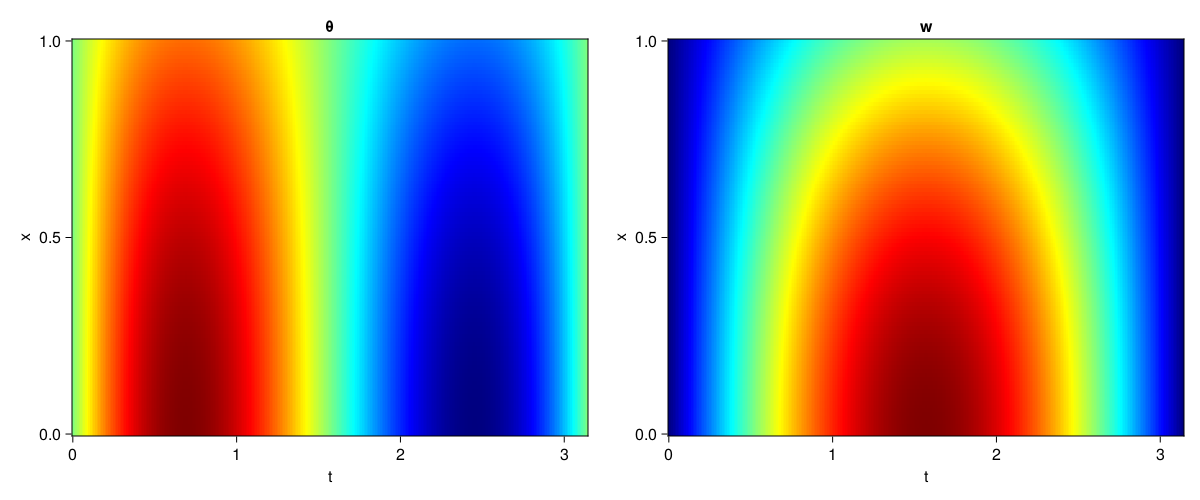

In [62]:
phi = pinn.phi
ps = res.u

xs, ts= [infimum(d.domain):0.01:supremum(d.domain) for d in timo.domain]

θ = [sum(phi.θ(([x,t]), ps.θ)) for x in xs, t in ts]
w = [sum(phi.w(([x,t]), ps.w)) for x in xs, t in ts]

fig = Figure(resolution=(1200,500))
axis = (xlabel="t", ylabel="x", title="θ")
heatmap(fig[1,1], xs, ts, θ, axis=axis, colormap=:jet)
heatmap(fig[1, 2], xs, ts, w, axis= merge(axis, (; title="w")), colormap=:jet)
display(fig)

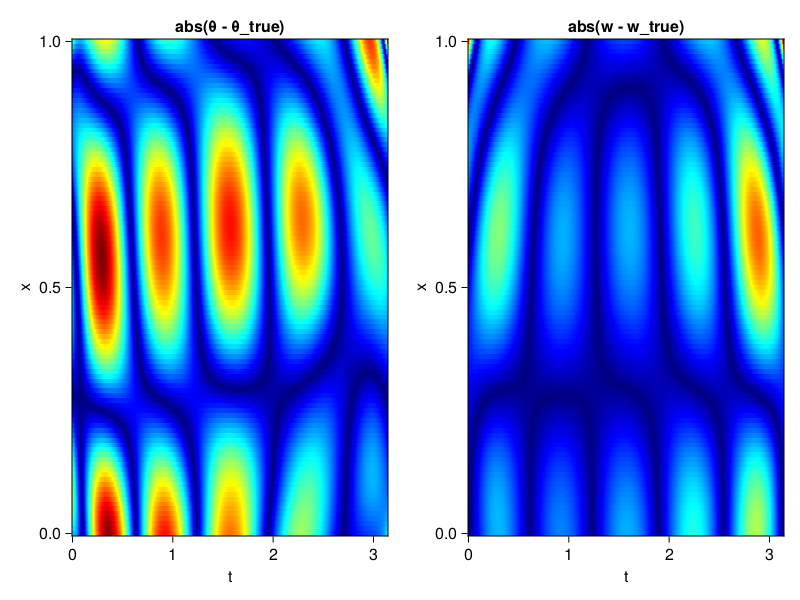

In [63]:
θ_analytic(x,t) = (π/2*cos(x) + x - π/2)*cos(t)
w_analytic(x,t) = π/2*sin(x)*cos(t)

θ_true = [θ_analytic(x,t) for x in xs, t in ts]
w_true = [w_analytic(x,t) for x in xs, t in ts]

axis = (xlabel="t", ylabel="x", title="abs(θ - θ_true)")
fig, ax1, hm1 = heatmap(xs, ts, abs.(θ .- θ_true), axis=axis, colormap=:jet)
ax2, hm2= heatmap(fig[1, 2], xs, ts, abs.(w .- w_true), axis= merge(axis, (; title="abs(w - w_true)")), colormap=:jet)
display(fig)